# Kuzushiji-49: An Introduction to CNNs

## Part 2: Image Classification with CNNs in Keras

### Introduction

Now that we have explored the data and verified some assumptions, we will proceed in Part 2 to apply deep learning models for the purposes of image classification.

In this notebook we will be using [Keras](https://keras.io/getting_started/), which has been integrated into the [Tensorflow](https://www.tensorflow.org/) deep learning framework proper since Version 2.0. 

Because we will doing deep learning which is computationally expensive, we will also be leveraging the free GPU computing available from [Google Colab](https://colab.research.google.com/). This will require some additional code to move the data from local into the cloud (Google Drive) and also some additional code for rendering the hiragana in plots which differs from on my local machine. We will address these points as the arise in the workflow.

As always, first we will the regular core libraries of the data science stack as before:

In [1]:
# holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the Data
As mentioned above, the data needed to be moved into the cloud in order to be read in Colab. Since the number of files and their sizes are relatively small, I simply uploaded these through the browser.



After this, we can mount Google Drive as a folder on the virtual machine backing the Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


The files in Google Drive are now available in the filesystem of the virtual machine at `/content/drive`. Let's just quickly check that all the data files are there by running a bash command using `!`:

In [3]:
!ls drive/MyDrive/kuzushiji/data/

k49_classmap.csv   k49-test-labels.npz	k49-train-labels.npz
k49-test-imgs.npz  k49-train-imgs.npz


Great, the files are there, so we can go ahead and load them all together in one cell:

In [4]:
# Reload the data

# Train
X_train = np.load('drive/MyDrive/kuzushiji/data/k49-train-imgs.npz')['arr_0']
y_train = np.load('drive/MyDrive/kuzushiji/data/k49-train-labels.npz')['arr_0']

# Test
X_test = np.load('drive/MyDrive/kuzushiji/data/k49-test-imgs.npz')['arr_0']
y_test = np.load('drive/MyDrive/kuzushiji/data/k49-test-labels.npz')['arr_0']

# Classmap
classmap = pd.read_csv('drive/MyDrive/kuzushiji/data/k49_classmap.csv')

### Adding a font for Japanese characters in Colab

Unfortunately, simply using the code which worked locally did not work here, and this required a little more doing. I followed the excellent guide here: [Using external fonts in Google Colaboratory](https://buomsoo-kim.github.io/colab/2018/04/27/Using-External-fonts-in-colab.md/). This follows a very similar procedure to the references pointed to in Part 1, through creating a `FontProperties` object in matplotlib, and then passing it to plotting / annotation / axis labeling / etc. calls where required.

For rendering Japanese characters, we'll be using [Noto Sans Japanese](https://fonts.google.com/noto/specimen/Noto+Sans+JP) from Google Fonts.

--2023-01-31 18:35:19--  https://fonts.google.com/download?family=Noto%20Sans%20JP
Resolving fonts.google.com (fonts.google.com)... 142.250.4.102, 142.250.4.101, 142.250.4.113, ...
Connecting to fonts.google.com (fonts.google.com)|142.250.4.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Noto_Sans_JP.zip’

Noto_Sans_JP.zip        [   <=>              ]  22.35M  42.0MB/s    in 0.5s    

2023-01-31 18:35:21 (42.0 MB/s) - ‘Noto_Sans_JP.zip’ saved [23439995]

Archive:  Noto_Sans_JP.zip
  inflating: OFL.txt                 
  inflating: NotoSansJP-Thin.otf     
  inflating: NotoSansJP-Light.otf    
  inflating: NotoSansJP-Regular.otf  
  inflating: NotoSansJP-Medium.otf   
  inflating: NotoSansJP-Bold.otf     
  inflating: NotoSansJP-Black.otf    


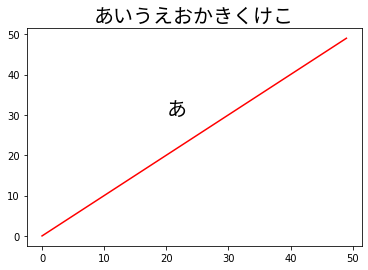

In [5]:
# Download the fonts and move to the user font directory
!yes | wget https://fonts.google.com/download?family=Noto%20Sans%20JP -O Noto_Sans_JP.zip
!unzip Noto_Sans_JP.zip
!mv *.otf /usr/share/fonts/truetype/

# Verify below with a sample plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Create FontProperties object using the file
path = '/usr/share/fonts/truetype/NotoSansJP-Regular.otf'
fontprop = fm.FontProperties(fname=path)

# Test
plt.plot(range(50), range(50), 'r')
plt.title('あいうえおかきくけこ', fontproperties=fontprop, fontsize=20)
plt.annotate('あ', (20, 30), fontproperties=fontprop, fontsize=20)
plt.show()

### Fundamentals of Deep Learning

Before we start building our deep learning model - a Convolution Neural Network, or CNN - I will introduce some of the fundamental concepts of machine learning and building blocks of how neural networks work.

First we must talk about what the goals of building a predictive model in supervised learning are: to make a prediction about the target (whether that be a class label or a continuous variable) and minimize the error (or, in a deep learning practitioner's parlance, the *loss*) in doing so.

In the case of simple linear models, this translates to an optimization problem where the goal is to find the *model parameters* or *coefficients* which minimize the loss - this is what the "learning" in machine learning is - the model is learning the parameters which will minimize the error of its predictions over the whole training dataset.

For a simple linear model for classification, were the goal is to predict the probability of the class label between 0 and 1, this takes the form of a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) - a special function called the *sigmoid functions* is applied to a linear combination of our $x$ variables and also includes an intercept, $\beta_0$ and coefficients which must be learned, in the vector $\beta$:

$\hat{y} = f(x) = \frac{1}{1 + \exp{-(\beta_0 + \beta X})}$

The end result for each observation and its values for each input variables (all the $x_i$ which make up $X$) is a value between 0 and 1, output as our $\hat{y}$.

### A Model of Models

In deep learning, many models are combined together in different *layers* and the outputs of previous layers are used as inputs from the next layer. Each model which makes up the different layers in the network is referred to as a *node*.

The first layer in the model, called  the *input* layer, is just the input data.The final layer in the model, called the *output* layer, combines all of the calculations from across the layers in-between - referred to as the *hidden layers* into our final prediction, $\hat{y}$.

![png](img/ann_diagram.png)

Now, instead of learning the same number of coefficients for the model as input features $x_i$, each node will have its own set of coefficients (or in deep learning speak, *weights*) based upon the outputs of the previous layer.

The number of hidden layers used and the number of weights present in each - collectively, making up what is referred to as the *model architecture* - is up to the modeller.

Given this, the number of coefficients in a deep learning model tends to grow very large; it is not unusual for neural networks to have millions of weights. This is from where the much of the predictive power of artifical neural network arises. It also comes at a price, as finding the optimal values for such a large number of weights to minimize the error - or *loss* - now becomes a very computationally challenging problem.   



### Modeling

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

## REVISE

The three steps of setting up a Keras neural network:
1. Instantiate the neural network (set up the architecture)
2. Compile the model
3. Train the model

In [7]:
input_shape = X_train.shape
print(input_shape)

(232365, 28, 28)


Here, we will need to actually reshape our image data and add a fourth dimension of size 1 - this is to be the channel dimension which for color images would normally be 3 (for R, G, B) but in this case since we are working with black and white images.

In [8]:
from tensorflow import expand_dims

X2 = expand_dims(X_train, axis=-1)

In [9]:
ks_model = Sequential()

ks_model.add(Input(shape=(28, 28, 1)))
ks_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Flatten())
ks_model.add(Dense(49, activation="softmax"))

In [10]:
ks_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:
ks_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 49)                7

In [12]:
X2.shape

TensorShape([232365, 28, 28, 1])

In [13]:
y2 = expand_dims(y_train, axis=-1)

In [14]:
y2.shape

TensorShape([232365, 1])

In [15]:
y2.shape

TensorShape([232365, 1])

In [16]:
from tensorflow import convert_to_tensor
y2 = convert_to_tensor(y_train)

In [17]:
np.floor(y_train.shape[0]*0.7).astype(int)

162655

In [18]:
pd.Series(y_train[np.floor(y_train.shape[0]*0.7).astype(int):]).value_counts()

21    1838
20    1838
35    1832
6     1830
9     1824
1     1822
17    1816
34    1815
41    1809
15    1806
47    1806
0     1805
5     1803
18    1803
12    1802
40    1801
30    1800
19    1796
7     1796
46    1795
28    1795
24    1791
10    1790
25    1786
38    1781
37    1780
11    1778
2     1761
39    1756
27    1742
4     1739
26    1535
8     1386
13    1215
14    1153
48    1091
33    1025
31     914
16     796
23     775
43     715
42     621
29     620
22     618
36     520
32     502
3      231
45     143
44     114
dtype: int64

In [19]:
history = ks_model.fit(X2, y2, epochs=10, validation_split=0.3)

Epoch 1/10
5083/5083 [==============================] - 29s 4ms/step - loss: 0.7673 - accuracy: 0.8191 - val_loss: 0.4074 - val_accuracy: 0.8881
Epoch 2/10
5083/5083 [==============================] - 33s 6ms/step - loss: 0.3501 - accuracy: 0.9041 - val_loss: 0.3390 - val_accuracy: 0.9068
Epoch 3/10
5083/5083 [==============================] - 24s 5ms/step - loss: 0.2850 - accuracy: 0.9199 - val_loss: 0.3066 - val_accuracy: 0.9174
Epoch 4/10
5083/5083 [==============================] - 24s 5ms/step - loss: 0.2493 - accuracy: 0.9288 - val_loss: 0.3027 - val_accuracy: 0.9179
Epoch 5/10
5083/5083 [==============================] - 25s 5ms/step - loss: 0.2268 - accuracy: 0.9344 - val_loss: 0.3092 - val_accuracy: 0.9187
Epoch 6/10
5083/5083 [==============================] - 22s 4ms/step - loss: 0.2093 - accuracy: 0.9394 - val_loss: 0.3182 - val_accuracy: 0.9194
Epoch 7/10
5083/5083 [==============================] - 21s 4ms/step - loss: 0.1982 - accuracy: 0.9417 - val_loss: 0.3224 - val_ac

In [20]:
history.history

{'loss': [0.7673015594482422,
  0.350089430809021,
  0.2850083112716675,
  0.24926000833511353,
  0.22682072222232819,
  0.2092631608247757,
  0.19822987914085388,
  0.19012174010276794,
  0.18058675527572632,
  0.1736450493335724],
 'accuracy': [0.8191202282905579,
  0.904054582118988,
  0.9198733568191528,
  0.9288432598114014,
  0.934394896030426,
  0.9393993616104126,
  0.941735565662384,
  0.9440287947654724,
  0.9461314082145691,
  0.9482524394989014],
 'val_loss': [0.40738826990127563,
  0.33896327018737793,
  0.30663248896598816,
  0.3026922643184662,
  0.3092353940010071,
  0.31818506121635437,
  0.3224066495895386,
  0.3312598466873169,
  0.32874393463134766,
  0.3636241555213928],
 'val_accuracy': [0.8881222009658813,
  0.9067996144294739,
  0.9174293279647827,
  0.9178597331047058,
  0.9187204241752625,
  0.9193803071975708,
  0.9213025569915771,
  0.9143451452255249,
  0.9189786314964294,
  0.9149906635284424]}

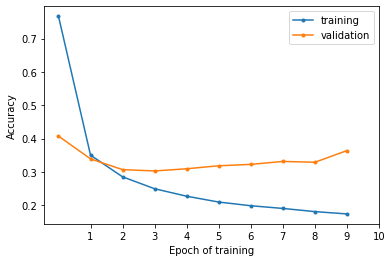

In [21]:
plt.plot(history.history['loss'], marker='.', label='training')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.xlabel('Epoch of training')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(10)+1)
plt.show()

In [22]:
y_proba = ks_model.predict(X_test)

1205/1205 [==============================] - 2s 2ms/step


In [23]:
# Crashed my kernel
#ks_model.evaluate(X_test, y_test)

In [24]:
y_proba.shape

(38547, 49)

In [25]:
y_pred = y_proba.argmax(axis=1)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
accuracy_score(y_test, y_pred)

0.8581990816405946

In [28]:
class_report = classification_report(y_test, y_pred, output_dict=True)

In [29]:
report_df = pd.DataFrame(class_report).T

report_df.head()

,precision,recall,f1-score,support
0,0.872778,0.933000,0.901885,1000.0
1,0.951515,0.942000,0.946734,1000.0
2,0.926633,0.922000,0.924311,1000.0
3,0.740260,0.904762,0.814286,126.0
4,0.911432,0.885000,0.898021,1000.0


In [30]:
classmap.index = classmap.index.astype(str)

In [31]:
report_df_joined = report_df.join(classmap)
report_df_joined.head()

,precision,recall,f1-score,support,index,codepoint,char
0,0.872778,0.933000,0.901885,1000.0,0.0,U+3042,あ
1,0.951515,0.942000,0.946734,1000.0,1.0,U+3044,い
2,0.926633,0.922000,0.924311,1000.0,2.0,U+3046,う
3,0.740260,0.904762,0.814286,126.0,3.0,U+3048,え
4,0.911432,0.885000,0.898021,1000.0,4.0,U+304A,お


In [32]:
report_df = report_df[0:49]
report_df.index = report_df.index.astype(int)

In [33]:
report_df.index = report_df.index.map(classmap['char'])

In [34]:
report_df_joined.loc['0', 'char']

'あ'

In [35]:
report_df_joined.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       'accuracy', 'macro avg', 'weighted avg'],
      dtype='object')

In [36]:
!ls /usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf

cmb10.ttf			DejaVuSerif.ttf
cmex10.ttf			LICENSE_DEJAVU
cmmi10.ttf			LICENSE_STIX
cmr10.ttf			STIXGeneralBolIta.ttf
cmss10.ttf			STIXGeneralBol.ttf
cmsy10.ttf			STIXGeneralItalic.ttf
cmtt10.ttf			STIXGeneral.ttf
DejaVuSans-BoldOblique.ttf	STIXNonUniBolIta.ttf
DejaVuSans-Bold.ttf		STIXNonUniBol.ttf
DejaVuSansDisplay.ttf		STIXNonUniIta.ttf
DejaVuSansMono-BoldOblique.ttf	STIXNonUni.ttf
DejaVuSansMono-Bold.ttf		STIXSizFiveSymReg.ttf
DejaVuSansMono-Oblique.ttf	STIXSizFourSymBol.ttf
DejaVuSansMono.ttf		STIXSizFourSymReg.ttf
DejaVuSans-Oblique.ttf		STIXSizOneSymBol.ttf
DejaVuSans.ttf			STIXSizOneSymReg.ttf
DejaVuSerif-BoldItalic.ttf	STIXSizThreeSymBol.ttf
DejaVuSerif-Bold.ttf		STIXSizThreeSymReg.ttf
DejaVuSerifDisplay.ttf		STIXSizTwoSymBol.ttf
DejaVuSerif-Italic.ttf		STIXSizTwoSymReg.ttf


In [37]:
!wget https://fonts.google.com/download?family=Noto%20Sans%20Javanese -O NotoSans.zip

--2023-01-31 18:39:53--  https://fonts.google.com/download?family=Noto%20Sans%20Javanese
Resolving fonts.google.com (fonts.google.com)... 142.250.4.102, 142.250.4.113, 142.250.4.100, ...
Connecting to fonts.google.com (fonts.google.com)|142.250.4.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘NotoSans.zip’

NotoSans.zip            [ <=>                ] 373.68K  2.36MB/s    in 0.2s    

2023-01-31 18:39:54 (2.36 MB/s) - ‘NotoSans.zip’ saved [382644]



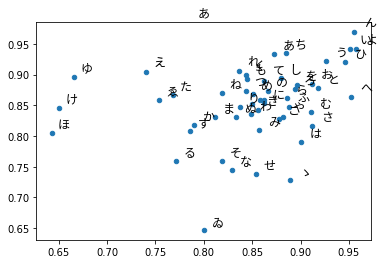

In [43]:
#matplotlib.rcParams['font.sans-serif'] = ['Noto Sans Japanese', 'sans-serif']

plt.scatter(report_df_joined['precision'], report_df_joined['recall'], s=20)

for i in np.arange(49).astype(str):
    
    plt.annotate(report_df_joined.loc[i,'char'], (report_df_joined.loc[i, 'precision']*1.01, report_df_joined.loc[i, 'recall']*1.01),
                fontsize=12, fontproperties=fontprop)
    
    plt.title("あ", fontproperties=fontprop)


plt.show()